# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center> Лабораторная работа №2. Рекомендательные системы </center>

* В данной лабораторной работе вам предлагается разработать алгоритм рекомендации фильмов.  
* Рекомендацией пользователю будем считать подборку из 10 фильмов.  
* Ожидаемый результат - эти фильмы пользователю понравятся и он высоко их оценит (weak assumption). 

### Задания  
  
1. Выполните разведывательный анализ данных (EDA).  
2. Разработайте алгоритм рекомендации фильмов пользователю. Используйте различные подходы: collaborative filtering (user to user, item to item), content-based, гибридный.  
3. Предложите способ оценки качества алгоритма и оцените качество различных подходов и моделей из предыдущего пункта.  
4. Опишите недостатки и ограничения предложенных вами моделей/алгоритмов и предложите возможные решения для борьбы с ними. 

### Данные 

Данные находятся в архиве `ml-latest-small.zip`.  
Они представляют из себя оценки 9742 фильмов, выставленные 610 пользователями. 
Также для некоторых фильмов известна информация о жанрах в виде тегов.

**Tip:** Вы можете самостоятельно добыть дополнительную информацию о фильмах, используя открытые (или закрытые) источники. Например, данные с IMDb, для взаимодействия с которой есть [специальный модуль](https://github.com/alberanid/imdbpy).  
**NB:** Использование дополнительных данных положительно скажется на оценке.

In [1]:
with open('data/README.txt') as f:
    desc = f.read()

print(desc)

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
movies = pd.read_csv('data/movies.csv')

In [3]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
links = pd.read_csv('data/links.csv')
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags = pd.read_csv('data/tags.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
# movies_trans = pd.read_csv('data/movies_trans.csv')
# movies_trans.head(10)

,Unnamed: 0,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,Toy Story,1995
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995
2,2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,Waiting to Exhale,1995
4,4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,Father of the Bride Part II,1995
5,5,6,Heat (1995),Action|Crime|Thriller,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,Heat,1995
6,6,7,Sabrina (1995),Comedy|Romance,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,Sabrina,1995
7,7,8,Tom and Huck (1995),Adventure|Children,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,Tom and Huck,1995
8,8,9,Sudden Death (1995),Action,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Sudden Death,1995
9,9,10,GoldenEye (1995),Action|Adventure|Thriller,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,GoldenEye,1995


In [10]:
movies_trans.head(5)

,Unnamed: 0,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,Toy Story,1995
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995
2,2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,Waiting to Exhale,1995
4,4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,Father of the Bride Part II,1995


In [7]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


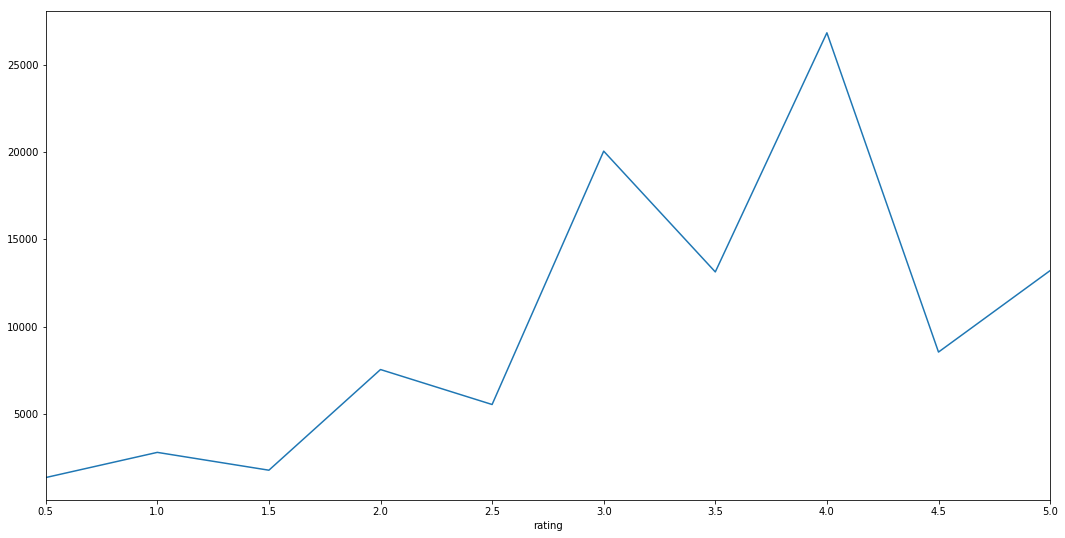

In [8]:
plt.rcParams['figure.figsize']=(18,9)

data_groupby_ratings = ratings.groupby(['rating'])['movieId'].count()
data_groupby_ratings.plot()

In [9]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [10]:
genres=['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [11]:
movies_trans=movies.copy()

In [12]:
for genre in genres:
    movies_trans[genre] = pd.Series(np.zeros(movies_trans.shape[0]), index=movies_trans.index)

In [13]:
movies_trans.head(3)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
for i in range(movies_trans.shape[0]):
    for genre in genres:
        movies_trans.loc[i,genre]=(genre in movies_trans.loc[i,'genres'])

In [15]:
movies_trans.head(3)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [16]:
def get_year(title):
    l = title.rfind('(') + 1
    try:
        return int(title[l:l+4])
    except ValueError:
        print(title, end='\t')
        return 0

In [17]:
def munge_title(title):
    i = title.rfind(' (')
    if i != -1:
        title = title[:i]
    for suff_word in ['The', 'A', 'An']:
        suffix = ', {}'.format(suff_word)
        if title.endswith(suffix):
            title = suff_word + ' ' + title[:-len(suffix)]
    return title

In [18]:
movies_trans['key'] = movies_trans['title'].map(munge_title)

movies_trans['year'] = movies_trans['title'].map(get_year)

Babylon 5	Ready Player One	Hyena Road	The Adventures of Sherlock Holmes and Doctor Watson	Nocturnal Animals	Paterson	Moonlight	The OA	Cosmos	Maria Bamford: Old Baby	Generation Iron 2	Black Mirror	

In [19]:
movies_trans.head(5)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,Father of the Bride Part II,1995


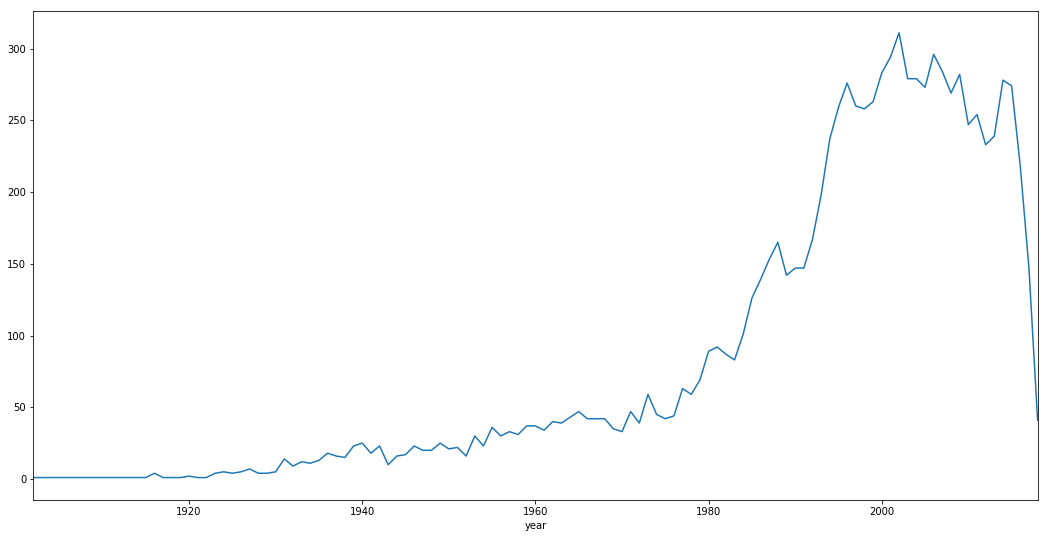

In [20]:
plt.rcParams['figure.figsize']=(18,9)
movies_trans[movies_trans.year!=0].groupby(['year'])['movieId'].count().plot()

In [21]:
popular_years=movies_trans.groupby(['year'])['movieId'].count().sort_values(ascending=False)[:10]
print(popular_years)
popular_years=popular_years.index.tolist()
print("-"*30)
print(movies_trans.groupby(['year'])['movieId'].count().sort_values(ascending=True)[:10])
print("-"*30)
movies_trans[movies_trans.year==0].shape[0]

year
2002    311
2006    296
2001    294
2007    284
2000    283
2009    282
2003    279
2004    279
2014    278
1996    276
Name: movieId, dtype: int64
------------------------------
year
1922    1
1902    1
1903    1
1908    1
1915    1
1917    1
1919    1
1921    1
1920    2
1916    4
Name: movieId, dtype: int64
------------------------------


12

In [22]:
movies_trans['year'].describe()

count    9742.000000
mean     1992.157873
std        72.375390
min         0.000000
25%      1987.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

In [23]:
movies_trans[movies_trans.year!=0]['year'].describe()

count    9730.000000
mean     1994.614800
std        18.534626
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

In [24]:
features=genres.copy()
features.append('year')

In [25]:
def create_users_ratings_dict(data_frame):
    users_ratings = {}
    for _, row in data_frame.iterrows():
        user_id =int(row["userId"])
        movie_id = int(row["movieId"])
        if user_id not in users_ratings:
            users_ratings[user_id] = {}
        users_ratings[user_id][movie_id] = row["rating"]
    return users_ratings

In [26]:
def create_movies_vector(data_frame, features):
    id_to_title = {}
    movie_index_to_movie_id = []
    movies_vectors = []
    for _, row in data_frame.iterrows():
        movie_id = int(row["movieId"])
        id_to_title[movie_id] = row["title"]
        movie_index_to_movie_id.append(movie_id)
        movies_vectors.append(np.array([row[feature] for feature in features]))
    return id_to_title, movie_index_to_movie_id, np.array(movies_vectors)

In [27]:
def replace_na_in_year():
    _, _, movies_vectors_ = create_movies_vector(movies_trans[movies_trans.year!=0], genres)
    nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
    nbrs.fit(movies_vectors_)
    _, movie_index_to_movie_id_, movies_vectors_na_year = create_movies_vector(movies_trans[movies_trans.year==0], genres)

    for i in range(len(movies_vectors_na_year)):
        neighbors_ids = nbrs.kneighbors([np.array(movies_vectors_na_year[i])], 10, return_distance=False)[0]
        year=round(np.average(
            np.array([
                movies_trans[movies_trans.year!=0].loc[id_]["year"]
            for id_ in neighbors_ids])))
        movies_trans.loc[movies_trans.movieId==movie_index_to_movie_id_[i],'year']=year

In [28]:
replace_na_in_year()

In [29]:
movies_trans['year'].describe()

count    9742.000000
mean     1994.622767
std        18.525795
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

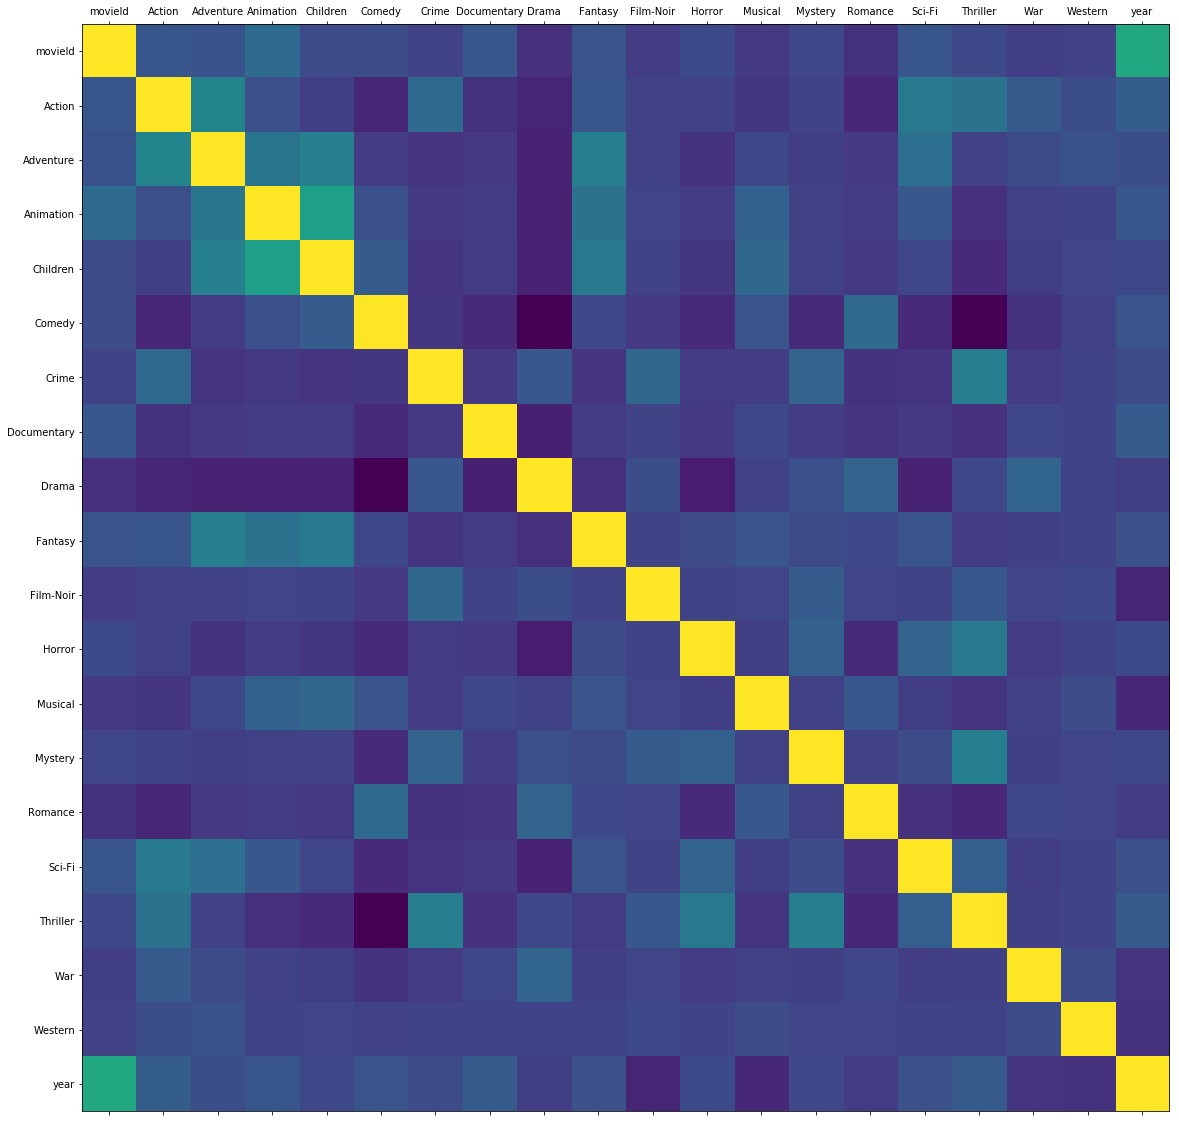

In [30]:
corr = movies_trans.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [31]:
plt.rcParams['figure.figsize']=(18,9)
movies_trans.groupby(['year'])[genres].aggregate(sum)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,
1902.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1903.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1908.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1915.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1916.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1917.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1919.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1920.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1921.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


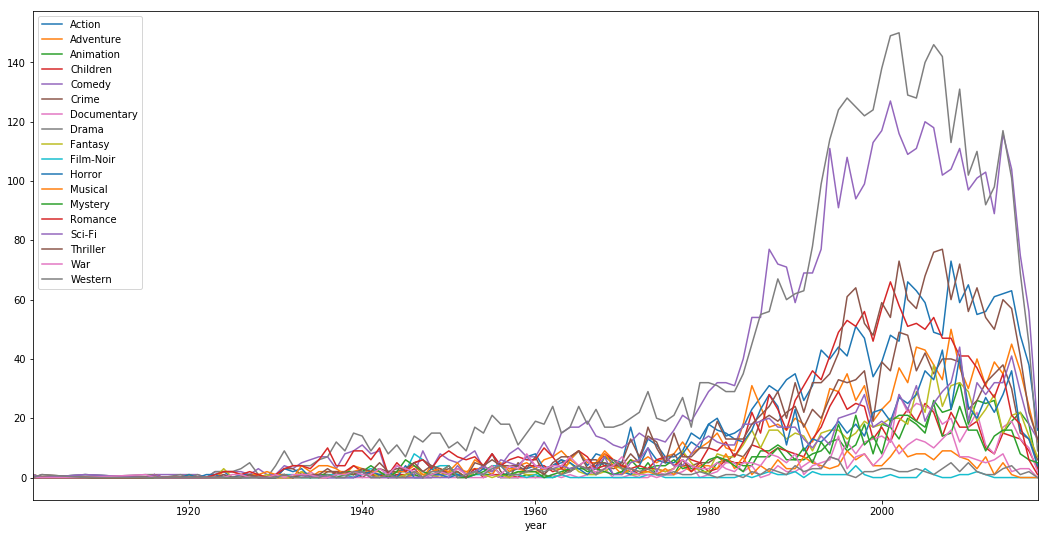

In [32]:
plt.rcParams['figure.figsize']=(18,9)
movies_trans[movies_trans.year!=0].groupby(['year'])[genres].aggregate(sum).plot()

In [33]:
def genres_by_period(start, end):
    plt.rcParams['figure.figsize']=(18,9)
    movies_trans[(movies_trans['year']>start) & (movies_trans['year']<=end)].groupby(['year'])[genres].aggregate(sum).plot()

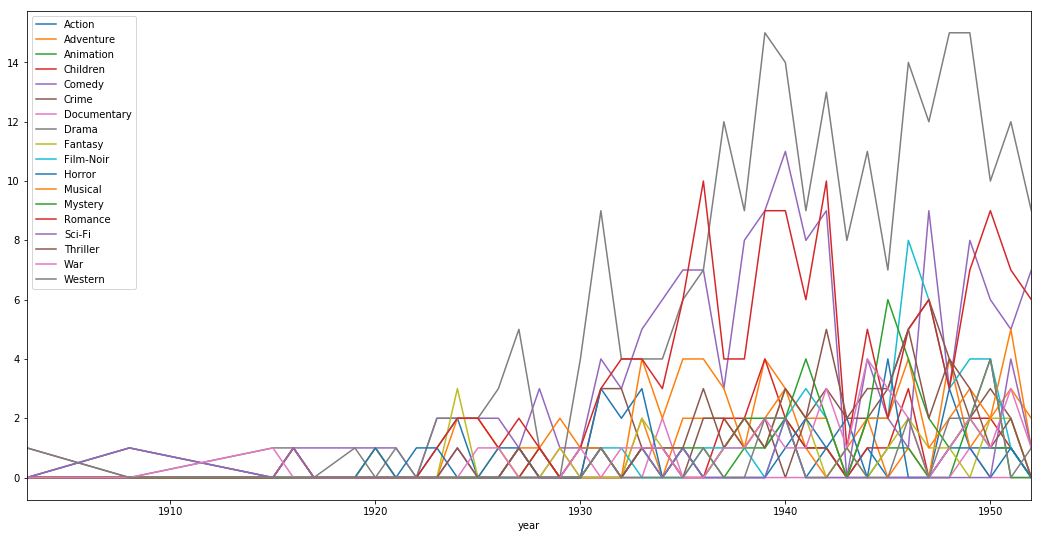

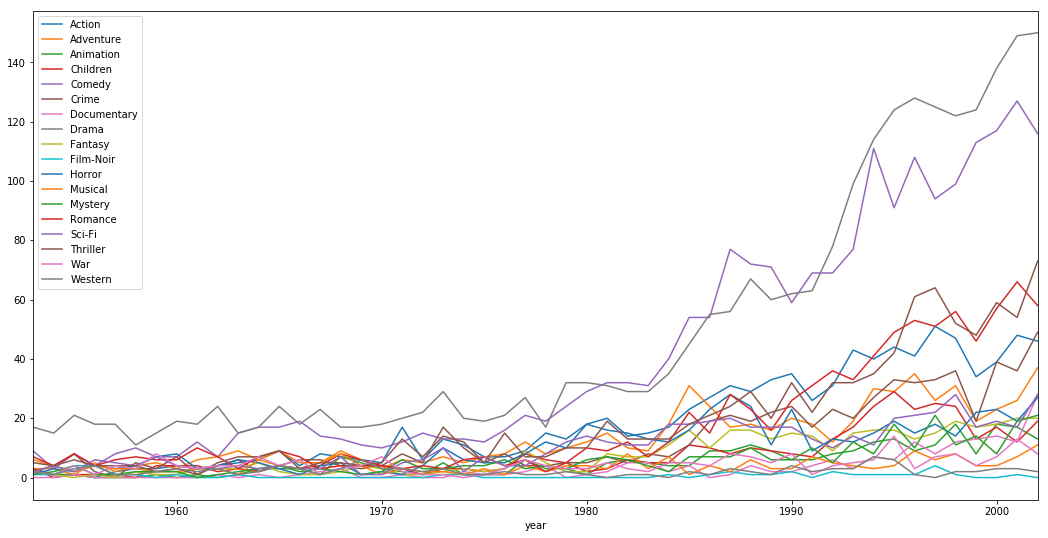

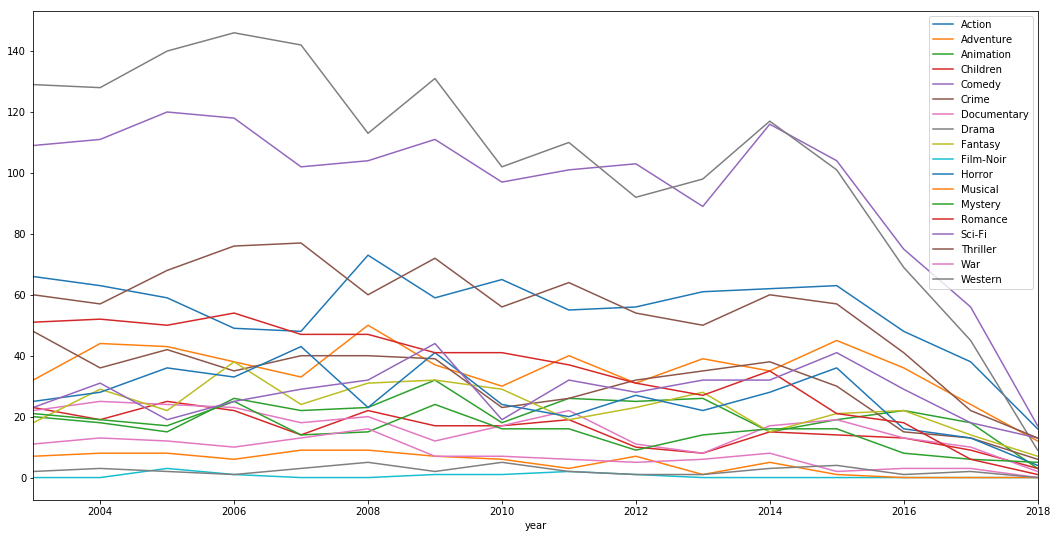

In [36]:
start=movies_trans['year'].min() 
end=0
step=50
while end < movies_trans['year'].max():
    end=start+50
    genres_by_period(start, end)
    start=end

In [37]:
movies_trans.drop(['movieId','title','genres','key','year'], axis=1).sum()

Action         1828
Adventure      1263
Animation       611
Children        664
Comedy         3756
Crime          1199
Documentary     440
Drama          4361
Fantasy         779
Film-Noir        87
Horror          978
Musical         334
Mystery         573
Romance        1596
Sci-Fi          980
Thriller       1894
War             382
Western         167
dtype: int64

In [38]:
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [39]:
movies_trans.head(5)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,Toy Story,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,Father of the Bride Part II,1995.0


In [40]:
def print_wordcloud(genre_name, words):
    wc= WordCloud(background_color="black",max_words=30)
    wc.generate(" ".join(words))
    plt.figure(figsize=(10,10))
    plt.title("Popular words in " + genre_name, fontsize=10)
    plt.imshow(wc.recolor(colormap= 'viridis'))
    plt.show()

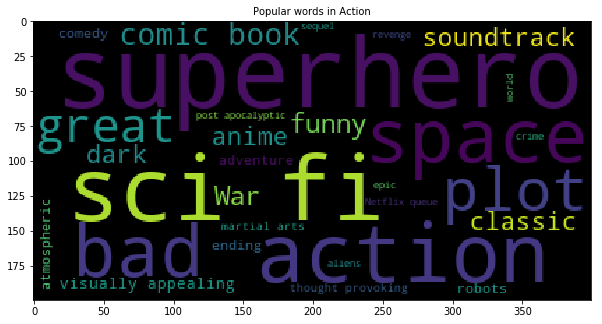

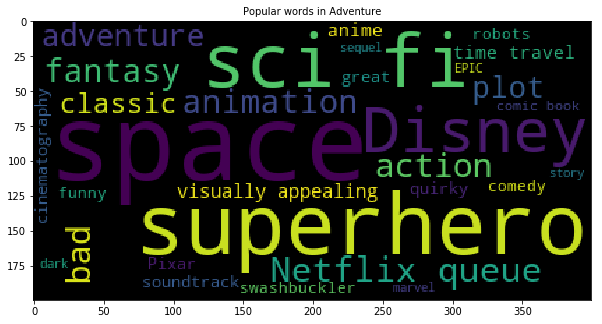

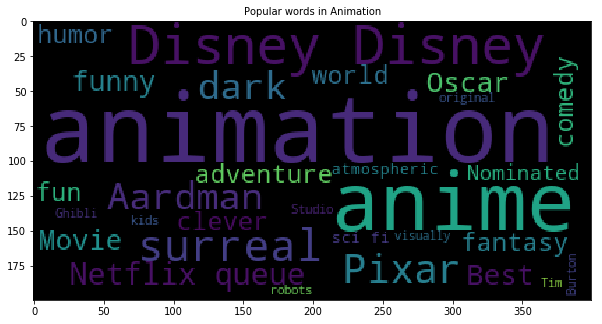

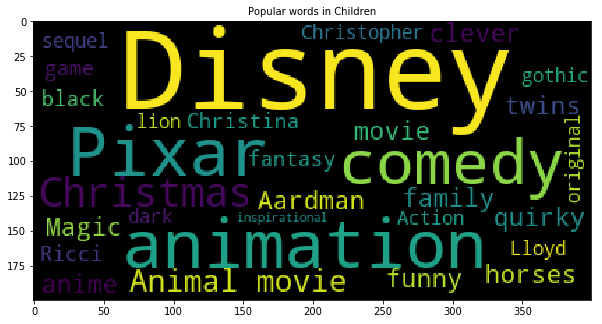

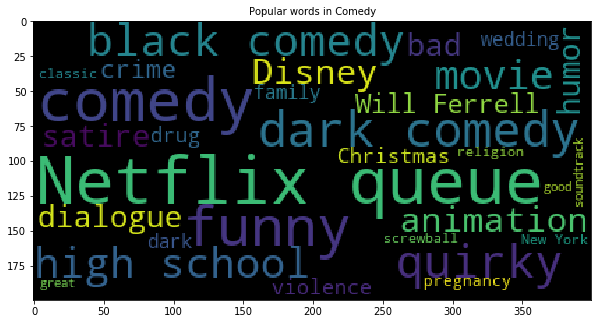

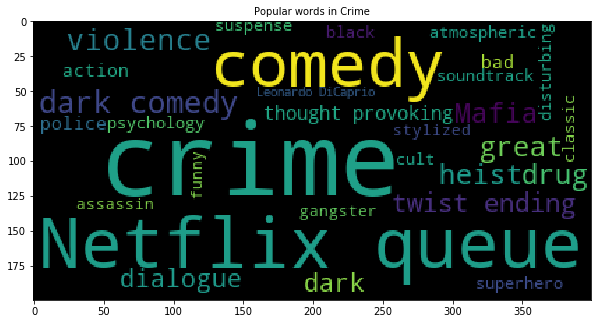

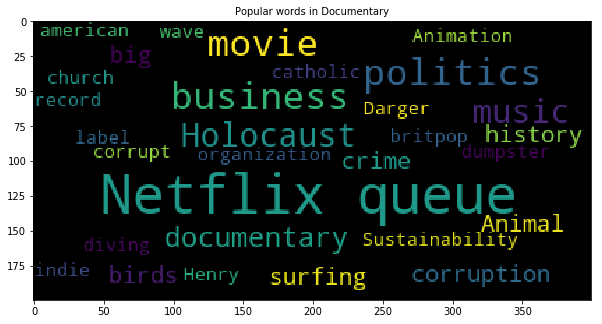

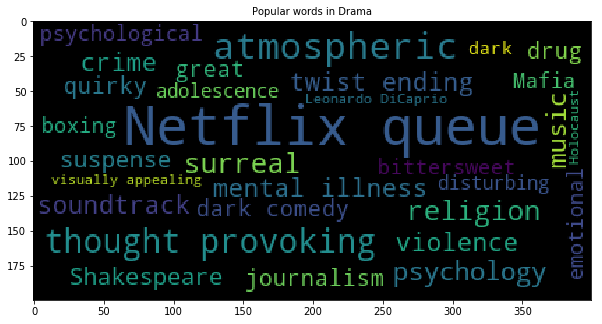

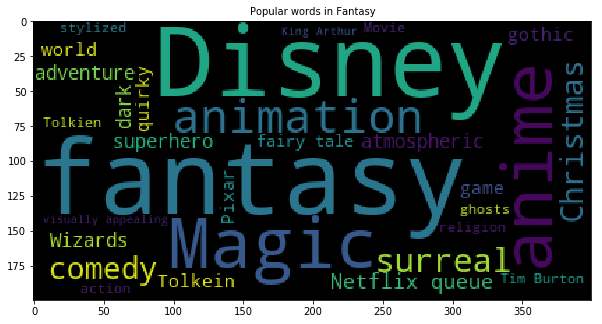

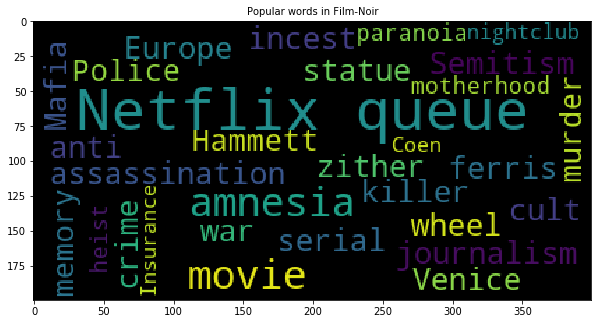

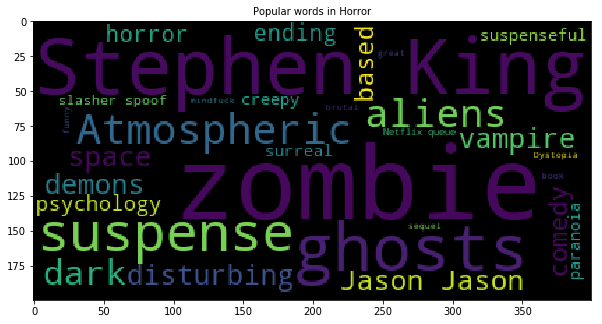

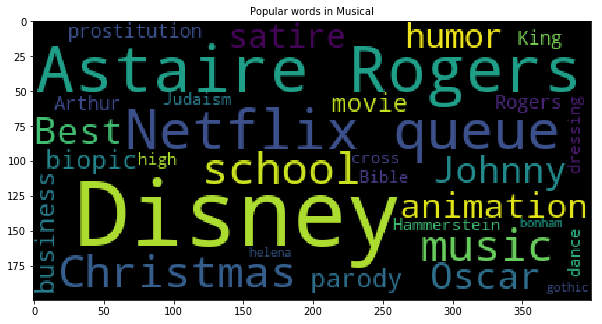

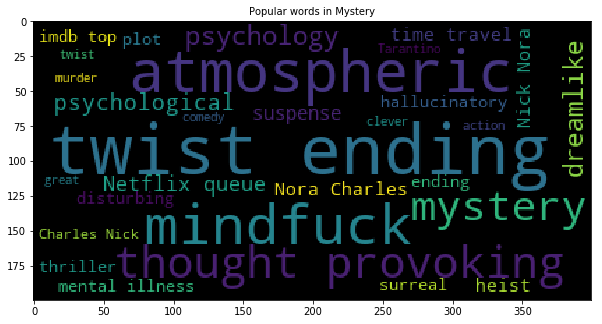

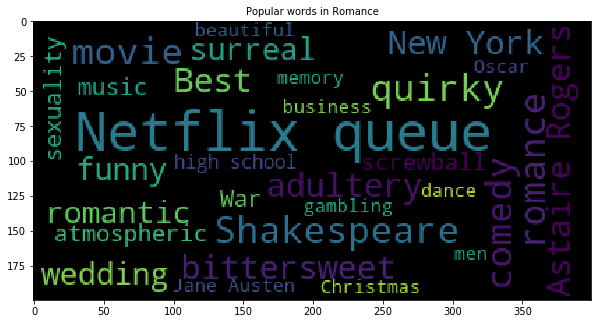

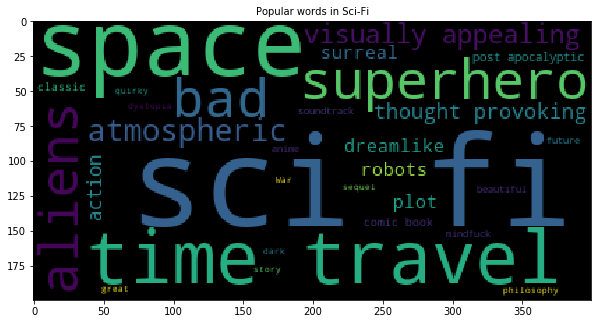

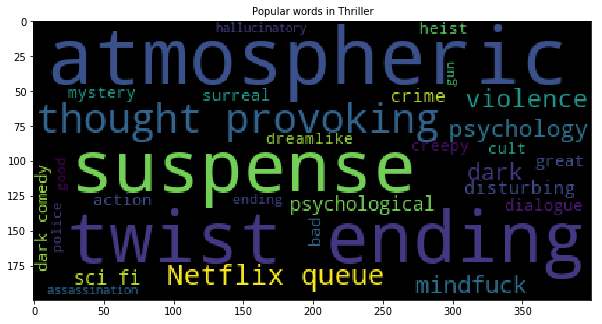

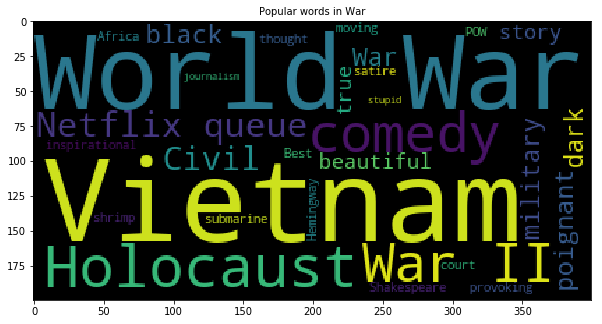

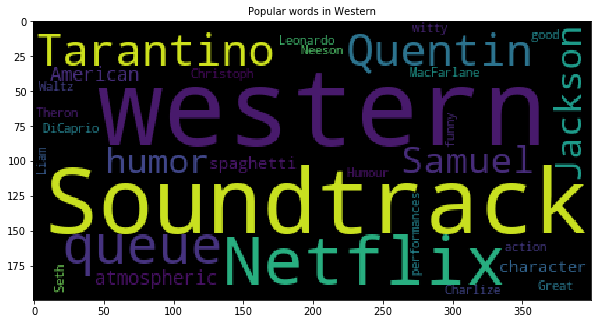

In [41]:
for genre in genres:
    ids=list(movies_trans[movies_trans[genre]==True]["movieId"].values)
    print_wordcloud(genre,list(tags.loc[tags['movieId'].isin(ids)]["tag"]))

In [42]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [43]:
movies_trans.head(5)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,Toy Story,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,Father of the Bride Part II,1995.0


In [44]:
def top_5_rated_movies(min_reviews):
    mean_ratings={}
    for movie in movies_trans['movieId'].values:
        collected_rating=ratings.loc[ratings['movieId']==movie]["rating"]
        if collected_rating.count() >=min_reviews:
            mean_ratings[movie]=collected_rating.mean()
    top_5_rating = sorted(mean_ratings.items(),key=lambda kv: -kv[1])[:5]
    for top in top_5_rating:
        print(movies_trans[movies_trans.movieId==top[0]]["title"])
        print(ratings.loc[ratings['movieId']==top[0]]["rating"].describe())
        print("*"*30)

In [45]:
top_5_rated_movies(5)

4396    Trial, The (Procès, Le) (1962)
Name: title, dtype: object
count    5.000000
mean     4.900000
std      0.223607
min      4.500000
25%      5.000000
50%      5.000000
75%      5.000000
max      5.000000
Name: rating, dtype: float64
******************************
9618    Three Billboards Outside Ebbing, Missouri (2017)
Name: title, dtype: object
count    8.000000
mean     4.750000
std      0.267261
min      4.500000
25%      4.500000
50%      4.750000
75%      5.000000
max      5.000000
Name: rating, dtype: float64
******************************
5773    Memories of Murder (Salinui chueok) (2003)
Name: title, dtype: object
count    5.000000
mean     4.700000
std      0.447214
min      4.000000
25%      4.500000
50%      5.000000
75%      5.000000
max      5.000000
Name: rating, dtype: float64
******************************
1664    Swept Away (Travolti da un insolito destino ne...
Name: title, dtype: object
count    6.000000
mean     4.666667
std      0.516398
min      4.000000
25%

In [46]:
top_5_rated_movies(20)

841    Streetcar Named Desire, A (1951)
Name: title, dtype: object
count    20.000000
mean      4.475000
std       0.658447
min       3.000000
25%       4.000000
50%       4.750000
75%       5.000000
max       5.000000
Name: rating, dtype: float64
******************************
277    Shawshank Redemption, The (1994)
Name: title, dtype: object
count    317.000000
mean       4.429022
std        0.713019
min        1.000000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: rating, dtype: float64
******************************
704    Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Name: title, dtype: object
count    27.000000
mean      4.333333
std       0.665062
min       2.500000
25%       4.000000
50%       4.500000
75%       5.000000
max       5.000000
Name: rating, dtype: float64
******************************
680    Philadelphia Story, The (1940)
Name: title, dtype: object
count    29.000000
mean      4.310345
std       0.783921
min       2.000000
2

In [47]:
def top_5_reviewed_movies():
    review_count={}
    for movie in movies_trans['movieId'].values:
        collected_rating=ratings.loc[ratings['movieId']==movie]["rating"]
        review_count[movie]=collected_rating.count()
    top_5_reviewed = sorted(review_count.items(),key=lambda kv: -kv[1])[:5]
    for top in top_5_reviewed:
        print(movies_trans[movies_trans.movieId==top[0]]["title"])
        print(ratings.loc[ratings['movieId']==top[0]]["rating"].describe())
        print("*"*30)

In [48]:
top_5_reviewed_movies()

314    Forrest Gump (1994)
Name: title, dtype: object
count    329.000000
mean       4.164134
std        0.831244
min        0.500000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64
******************************
277    Shawshank Redemption, The (1994)
Name: title, dtype: object
count    317.000000
mean       4.429022
std        0.713019
min        1.000000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: rating, dtype: float64
******************************
257    Pulp Fiction (1994)
Name: title, dtype: object
count    307.000000
mean       4.197068
std        0.951997
min        0.500000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: rating, dtype: float64
******************************
510    Silence of the Lambs, The (1991)
Name: title, dtype: object
count    279.000000
mean       4.161290
std        0.853983
min        0.500000
25%        4.00000

In [49]:
movies_trans.head(3)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,Toy Story,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,Grumpier Old Men,1995.0


In [50]:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}

In [51]:
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

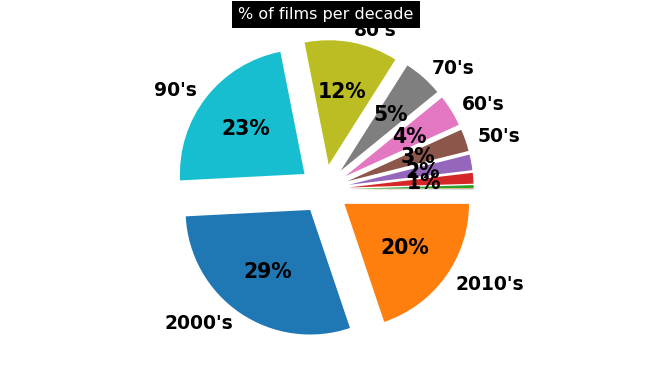

In [67]:
movies_trans['decade'] = movies_trans['year'].apply(lambda x:((x-1900)//10)*10)
 
test = movies_trans['year'].groupby(movies_trans['decade']).apply(get_stats).unstack()
 
sns.set_context("poster", font_scale=0.85)
 
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
 
explode = [0.2 for i in range(12)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
movies_trans.drop('decade', axis=1, inplace = True)

In [70]:
movies_trans.to_csv('data/movies_trans.csv')

In [63]:
movies_trans = pd.read_csv('data/movies_trans.csv')
movies_trans.head(3)

,Unnamed: 0,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,key,year,decade
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,True,True,True,True,False,...,False,False,False,False,False,False,False,Toy Story,1995.0,90.0
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,False,True,False,True,False,False,...,False,False,False,False,False,False,False,Jumanji,1995.0,90.0
2,2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,...,False,False,True,False,False,False,False,Grumpier Old Men,1995.0,90.0


# Content-based

In [149]:
class ContentBasedRecommender(object):
    def __init__(self, id_to_title, movie_index_to_movie_id, movies_vectors):
        self.id_to_title = id_to_title
        self.movie_index_to_movie_id = movie_index_to_movie_id
        self.movies_vectors = movies_vectors
    
    def train(self, train_set):
        pass
    
    def top_N(self, user_profile, top_N):
        return self._KNN_all_movies(user_profile[0], top_N)
    
    def predict_rating(self, user_profile, movie_id):
        nearest_watched_movies = self._KNN_movies_subset(list(user_profile[1].keys()), movie_id, 5)
        return np.average(np.array([user_profile[1][movie] for movie in nearest_watched_movies]))
        
    def create_user_profile(self, user_ratings):
        return (
            np.average(np.array([
                self.movies_vectors[self.movie_index_to_movie_id.index(movie)]
                for (movie, rating) in user_ratings.items()]),
                    weights=np.array(list(user_ratings.values())),
                    axis=0),
            user_ratings)
    
    def show_user_profile(self, user_profile):
        print (f"User favourite genre: {genres[np.argmax(user_profile[0][:-1])]}")
        print (f"User mean year: {np.mean(user_profile[0][-1])}")
        print (f"User mean rating: {np.mean(list(user_profile[1].values()))}")
        print ("User ratings:")
        for (movie_id, rating) in user_profile[1].items():
            movie_vector = self.movies_vectors[self.movie_index_to_movie_id.index(movie_id)]
            print (f"{self.id_to_title[movie_id]} \
                   {[genres[i] for i, x in enumerate(movie_vector[:-1]) if x == 1]}  {rating}")
    
    def show_recommendations(self, recommendations):
        print ("Recommended movies:")
        for movie_id in recommendations:
            movie_vector = self.movies_vectors[self.movie_index_to_movie_id.index(movie_id)]
            print (f"{movie_id}: {self.id_to_title[movie_id]} --- \
                {[genres[i] for i, x in enumerate(movie_vector) if x == 1]}")
    
    def _KNN_all_movies(self, user_profile, k):
        nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
        nbrs.fit(self.movies_vectors)
        indices = nbrs.kneighbors(np.array([user_profile]), k, return_distance=False)[0]
        return [self.movie_index_to_movie_id[index] for index in indices]
    
    def _KNN_movies_subset(self, movies_subset, movie_id, k):
        nbrs = NearestNeighbors(k, metric='cosine', algorithm='brute')
        movies_with_ids = np.array([
                                np.hstack([[watched_movie], 
                                           self.movies_vectors[self.movie_index_to_movie_id.index(watched_movie)]])
                                for watched_movie in movies_subset])
        nbrs.fit(movies_with_ids[:, 1:])
        return movies_with_ids[nbrs.kneighbors(
                            np.array([self.movies_vectors[self.movie_index_to_movie_id.index(movie_id)]]), 
                                            return_distance=False)[0],0]

In [73]:
user_ratings = create_users_ratings_dict(ratings)

In [74]:
id_to_title, movie_index_to_movie_id, movies_vectors = create_movies_vector(movies_trans, features)

In [75]:
movies_vectors[0]

array([0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.995e+03])

In [150]:
recommender = ContentBasedRecommender(id_to_title, movie_index_to_movie_id, movies_vectors)
user_profile = recommender.create_user_profile(user_ratings[11])
recommender.show_user_profile(user_profile)

User favourite genre: Action
User mean year: 1994.7727272727273
User mean rating: 3.78125
User ratings:
Heat (1995)                    ['Action', 'Crime', 'Thriller']  5.0
GoldenEye (1995)                    ['Action', 'Adventure', 'Thriller']  3.0
Dead Man Walking (1995)                    ['Crime', 'Drama']  4.0
Mortal Kombat (1995)                    ['Action', 'Adventure', 'Fantasy']  2.0
Broken Arrow (1996)                    ['Action', 'Adventure', 'Thriller']  3.0
Braveheart (1995)                    ['Action', 'Drama', 'War']  5.0
Apollo 13 (1995)                    ['Adventure', 'Drama']  5.0
Batman Forever (1995)                    ['Action', 'Adventure', 'Comedy', 'Crime']  3.0
Die Hard: With a Vengeance (1995)                    ['Action', 'Crime', 'Thriller']  3.0
Hackers (1995)                    ['Action', 'Adventure', 'Crime', 'Thriller']  4.0
Waterworld (1995)                    ['Action', 'Adventure', 'Sci-Fi']  3.0
Outbreak (1995)                    ['Action', 'Drama

In [151]:
top_5 = recommender.top_N(user_profile, top_N=5)
recommender.show_recommendations(top_5)

Recommended movies:
176935: Geostorm (2017) ---                 ['Action']
161290: Vigilante Diaries (2016) ---                 ['Action']
158402: The Crew (2016) ---                 ['Action']
160438: Jason Bourne (2016) ---                 ['Action']
160684: Marauders (2016) ---                 ['Action']


In [152]:
recommender.predict_rating(user_profile, 160438)

3.6